# **Long Short Therm Memory**

## Word Embedding: GloVe 6B 100d
##Optimizers: Adam/ SGD

**Word Embeddings**

Words and ngrams have been primarily used as features in text classification. I did vectorized the texts using bag of words based features, now I will rely on neural embedding models. I will use a pre-trained embedding model. There are several pre-trained word2vec models trained on large corpora that one can download from the internet. GloVe(Global Vector) is one of popular pre-trained embedding algorithm from Stanford.

The advantage of using embedding based features is that they create a dense, low-dimensional feature representation instead of the sparse, high-dimensional structure of bag of words/TFIDF and other such features.

**GloVe Embeddings**
GloVe is commonly used method of obtaining pre-trained embeddings. GloVe aims to achieve two goals:

Create word vectors that capture meaning in vector space
Takes advantage of global count statistics instead of only local information
There are a lot of online material available to explain the concept about GloVe. So my focus here will be on, how to use pre-trained Glove word embeddings. I will provide relevant resources to look into more details.

**Download the pre-trained glove file:**
I will be using glove.6B file which is trained on Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 100d vectors, 822 MB download).

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-10-05 18:17:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-05 18:17:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-05 18:17:34--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip -q ./glove.6B.zip

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


from tensorflow.keras import regularizers, initializers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam


from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve

MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 400 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "/content/glove.6B."+str(EMBEDDING_DIM)+"d.txt"


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[labels].values

**Preprocessing**

In [ ]:
def cleantxt(txt):
    """
    Cleans the string passed. Cleaning Includes-
    1. remove special characters/symbols
    2. convert text to lower-case
    3. retain only alphabets
    4. remove words less than 3 characters
    5. remove stop-words
    """
    # collecting english stop words from nltk-library
    stpw = stopwords.words('english')

    # Adding custom stop-words
    stpw.extend(['www','http','utc'])
    stpw = set(stpw)

    # using regex to clean the text
    txt = re.sub(r"\n", " ", txt)
    txt = re.sub("[\<\[].*?[\>\]]", " ", txt)
    txt = txt.lower()
    txt = re.sub(r"[^a-z ]", " ", txt)
    txt = re.sub(r"\b\w{1,3}\b", " ",txt)
    txt = " ".join([x for x in txt.split() if x not in stpw])
    return txt

In [ ]:
train.comment_text.loc[1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [ ]:
train.comment_text = train.comment_text.apply(lambda x : cleantxt(x))

In [ ]:
train.comment_text.loc[1]

'matches background colour seemingly stuck thanks talk january'

In [ ]:
comments_train = train['comment_text']
comments_train = list(comments_train)
comments_test = test['comment_text']
comments_test = list(comments_test)


**Evaluation Metric**

To evaluate the model, I'll be looking at its AUC ROC score (area under the receiver operating characteristic curve). I will be looking at the probability that the model ranks a randomly chosen positive instance higher than a randomly chosen negative one. With data that mostly consists of negative labels (no toxicity), our model could just learn to always predict negative and end up with a pretty high accuracy. AUC ROC helps correct this by putting more weight on the the positive examples.

In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [ ]:
def plot_graphs(history, metric, optimizer):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.title(optimizer)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

**Tokenizing**

When dealing with text, it is typical to assign a unique integer id to each word in the corpus. This makes it simpler to represent the data as we feed it into a model.

Because this is such a common operation, Keras has built-in support for it. We need to fit the tokenizer object on our corpus so that it can assign a unique id to each word. We also initialize the tokenizer with a num_words parameter so that it knows how many of the top frequency words to take into account.

**Padding**

Our model would expect each input row to be of the same dimension. This means once we decide on what the chosen input comment size is, we need to chop off some part of the input comments that are too long. We would also, need to pad the comments which are shorter.

Keras has built in support for this using the pad_sequences method.


In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(comments_train)
sequences = tokenizer.texts_to_sequences(comments_train)
test_sequences = tokenizer.texts_to_sequences(comments_test)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 161263


In [ ]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
data_test = pad_sequences(test_sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [ ]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...")
print(f'Found {len(embeddings_index)} word vectors', end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: /content/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix...
Found 400000 word vectors Completed!


**MODEL**

Recurrent Neural Network(RNN) with word embeddings

The RNN type model used here is the LSTM model. This model is attractive because the individual cell states in the model have the ability to remove or add information to the cell state through gates layers. This is useful in practice because it allows the model to remember insights derived from words throughout the comment. The LSTM model consist of one densely connected layer with 60 units across the concatenated word vectors for each of the words in the comment

Now that the data is preprocessed and our embeddings are ready, we can build a model. We will build a neural network architecture that is comprises of the following:

Embedding layer - word vector representations.
Recurrent layer (LSTM) - run multiple filters over the data.
Fully connected layer - classify input based on filters.

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

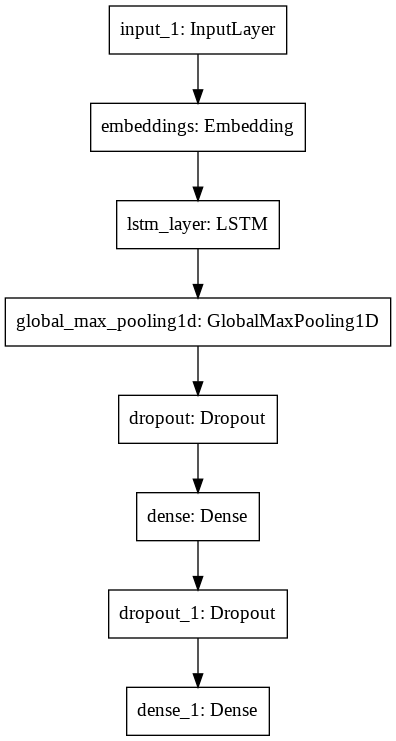

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
X_tra, X_val, y_tra, y_val = train_test_split(data, y, train_size=0.8, random_state=233)

In [ ]:
model = Model(sequence_input, preds)

In [ ]:
ra_val = RocAucEvaluation(validation_data=(X_val, y_val), interval = 1)
callbacks_list = [ra_val]

In [ ]:
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

In [ ]:
hist_adam = model.fit(X_tra, y_tra, batch_size=400, epochs=20, validation_data=(X_val, y_val),callbacks = callbacks_list,verbose=1)
print('Predicting....')
y_pred_Adam = model.predict(data_test,batch_size=1024,verbose=1)

Epoch 1/20
319/320 [============================>.] - ETA: 0s - loss: 0.1215 - accuracy: 0.7109
 ROC-AUC - epoch: 1 - score: 0.950208
320/320 [==============================] - 23s 72ms/step - loss: 0.1215 - accuracy: 0.7110 - val_loss: 0.0662 - val_accuracy: 0.9938
Epoch 2/20
320/320 [==============================] - ETA: 0s - loss: 0.0646 - accuracy: 0.9279
 ROC-AUC - epoch: 2 - score: 0.957167
320/320 [==============================] - 22s 70ms/step - loss: 0.0646 - accuracy: 0.9279 - val_loss: 0.0612 - val_accuracy: 0.9938
Epoch 3/20
319/320 [============================>.] - ETA: 0s - loss: 0.0603 - accuracy: 0.9631
 ROC-AUC - epoch: 3 - score: 0.961152
320/320 [==============================] - 23s 71ms/step - loss: 0.0603 - accuracy: 0.9631 - val_loss: 0.0589 - val_accuracy: 0.9938
Epoch 4/20
319/320 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9766
 ROC-AUC - epoch: 4 - score: 0.964339
320/320 [==============================] - 23s 70ms/step - loss: 

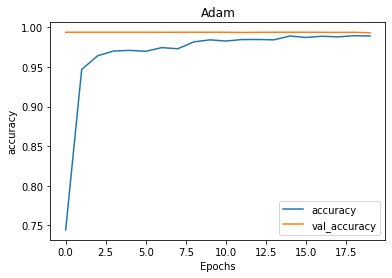

In [ ]:
plot_graphs(hist_adam, 'accuracy','Adam')

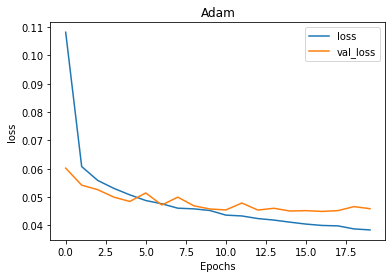

In [ ]:
plot_graphs(hist_adam, 'loss','Adam')

In [ ]:
submission = pd.read_csv('/content/submission_gru.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred_Adam
submission.to_csv('lstm_glove6b_adam_prepro2.csv', index=False)

SGD

In [ ]:
opt = SGD(lr=0.01, momentum=0.9, decay=0.0001)
model.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])

hist_sgd = model.fit(X_tra, y_tra, batch_size=400, epochs=20, validation_data=(X_val, y_val),callbacks = callbacks_list,verbose=1)
print('Predicting....')
y_pred_SGD = model.predict(data_test,batch_size=1024,verbose=1)

Epoch 1/20
320/320 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.7538
 ROC-AUC - epoch: 1 - score: 0.787165
320/320 [==============================] - 23s 73ms/step - loss: 0.1740 - accuracy: 0.7538 - val_loss: 0.1259 - val_accuracy: 0.9938
Epoch 2/20
319/320 [============================>.] - ETA: 0s - loss: 0.1273 - accuracy: 0.8534
 ROC-AUC - epoch: 2 - score: 0.836562
320/320 [==============================] - 23s 70ms/step - loss: 0.1274 - accuracy: 0.8534 - val_loss: 0.1170 - val_accuracy: 0.9938
Epoch 3/20
319/320 [============================>.] - ETA: 0s - loss: 0.1161 - accuracy: 0.8873
 ROC-AUC - epoch: 3 - score: 0.883239
320/320 [==============================] - 23s 71ms/step - loss: 0.1161 - accuracy: 0.8873 - val_loss: 0.1049 - val_accuracy: 0.9938
Epoch 4/20
320/320 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.9023
 ROC-AUC - epoch: 4 - score: 0.914819
320/320 [==============================] - 23s 71ms/step - loss: 

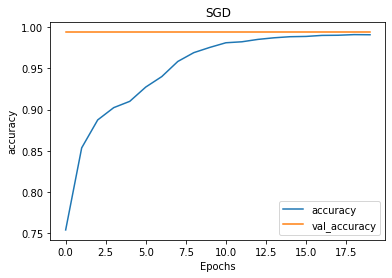

In [ ]:
plot_graphs(hist_sgd, 'accuracy','SGD')

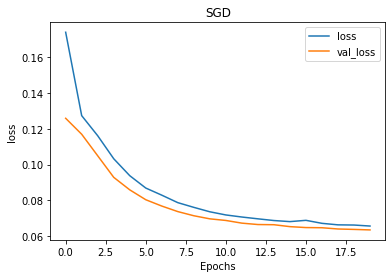

In [ ]:
plot_graphs(hist_sgd, 'loss','SGD')

In [ ]:
submission = pd.read_csv('/content/submission_gru.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred_SGD
submission.to_csv('lstm_glove6b_sgd_prepro2.csv', index=False)